## Libraries

In [7]:
!pip install --upgrade dcor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install minepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached minepy-1.2.6.tar.gz (496 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for minepy: filename=minepy-1.2.6-cp310-cp310-linux_x86_64.whl size=226757 sha256=4f79eb62a07299b52faa493998ea5e8646f96da24ac0f503308809475cba82b7
  Stored in directory: /root/.cache/pip/wheels/69/38/a6/825bb9b9ed81e6af43a0ef80c7cfe4cafcfdbc2f5cde2959d9
Successfully built minepy


In [9]:
import numpy as np
import pandas as pd
import random

#saves variables
import pickle 
#saves into files
from numpy import savetxt

# # MIC correlation
# from minepy import MINE

# # distance correlation
# import dcor
from scipy.spatial.distance import correlation


import matplotlib.pyplot  as plt
import seaborn as sns
# sns.set()

# LSTM
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc

from scipy.stats import multivariate_normal

In [10]:
class ADClass:

    def __init__(self, dataset_path):
        """
        Initialize dataset file path.
        """
        self.dataset_path = dataset_path
        self.LCVs = []
        self.df_categorical_fields = ['MV101', 'P101', 'P102', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P401', 'P402', 'P403', 'P404', 'UV401', 'P501', 'P502', 'P601', 'P602', 'P603']
        self.df_numerical_fields = ['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']
        

    def importDataset(self, file_name, nb_rows):
        if nb_rows == 0:
          return pd.read_excel(self.dataset_path + file_name, header=1)
        else:
          return pd.read_excel(self.dataset_path + file_name, header=1, nrows=nb_rows)

    def trimColumnName(slfe, df):

        return df.rename(columns=lambda x: x.strip())

    def splitDataset(self, df):
        x_n, y_n = df.iloc[:, :-1], df.iloc[:, [-1]]

        return  x_n, y_n

    def oneHotEncoding(self, fixed_value_list, x_n):
        new_cat_list = list(filter(lambda x: x not in fixed_value_list, self.df_categorical_fields))

        #creating instance of one-hot-encoder
        encoder = OneHotEncoder(handle_unknown='ignore')
        # One-hot-encode the categorical columns.
        enc_package_type = pd.DataFrame(encoder.fit_transform(x_n[new_cat_list]).toarray())
        #merge one-hot encoded columns back with original DataFrame
        x_n = x_n.join(enc_package_type)
        
        return x_n

    def removeCategorical(self, fixed_value_list, x_n):
        new_cat_list = list(filter(lambda x: x not in fixed_value_list, self.df_categorical_fields))
        x_n.drop(new_cat_list, axis=1, inplace=True)

        return x_n


    def createSequence(slef, x_n_scaled, window_size, shift):
        # Create sequences
        train_windows = []
        for i in range(0, x_n_scaled.shape[0] - window_size - shift, shift):
            train_windows.append(x_n_scaled[i:i+window_size])

        # Convert to numpy array
        x_w_train = np.array(train_windows)

        return x_w_train

    def windowDetectionLSTM(self, window_size_list, lstm_X_train, lstm_X_test, LSTM_w_shift):
        history_list = []
        mse_test = []

        for i in window_size_list:
          window_size = i

          # Create sequences
          train_windows = []
          test_windows = []

          x_w_train = AD_normal.createSequence(lstm_X_train, window_size, LSTM_w_shift)
          x_w_test = AD_normal.createSequence(lstm_X_test, window_size, LSTM_w_shift)

          # data dimensions // hyperparameters 
          input_dim = x_w_train.shape[2] 
          BATCH_SIZE = 256
          EPOCHS = 50

          # https://keras.io/layers/core/
          LSTM_model = keras.models.Sequential([
              
              # deconstruct / encode
              keras.layers.Dense(input_dim, activation='elu', input_shape=(x_w_train.shape[1], x_w_train.shape[2])), 
              keras.layers.Dense(16, activation='elu'),
              keras.layers.Dense(8, activation='elu'),
              keras.layers.Dense(4, activation='elu'),
              keras.layers.Dense(2, activation='elu'),
              
              # reconstruction / decode
              keras.layers.Dense(4, activation='elu'),
              keras.layers.Dense(8, activation='elu'),
              keras.layers.Dense(16, activation='elu'),
              keras.layers.Dense(input_dim, activation='elu')
              
          ])

          # # define our early stopping
          # early_stop = keras.callbacks.EarlyStopping(
          #     monitor='val_loss',
          #     min_delta=0.0001,
          #     patience=10,
          #     verbose=1, 
          #     mode='min',
          #     restore_best_weights=True
          # )


          # the default learning rate is used for the Adam optimizer, which is typically set to 0.001. 
          LSTM_model.compile(optimizer="adam", 
                              loss="mse",
                              metrics=["acc"])

          # print an overview of our model
          LSTM_model.summary();

          history = LSTM_model.fit(
            x_w_train,
            x_w_train,
            epochs=50,
            batch_size=128,
            validation_split=0.2,
            callbacks=[
                keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
            ],
          )

          plt.plot(history.history["loss"], label="Training Loss")
          plt.plot(history.history["val_loss"], label="Validation Loss")
          plt.legend()
          plt.show()

          # Generate predictions on the test set
          X_w_pred = LSTM_model.predict(x_w_test)

          # Evaluate the autoencoder
          mse = np.mean(np.power(x_w_test - X_w_pred, 2), axis=1)
          print("Mean Squared Error:", np.mean(mse))
          print()
          
          # save values 
          history_list.append(history)
          mse_test.append(np.mean(mse))
        
        return history_list, mse_test


    # /*
    # transposing the window array is necessary to ensure that each row represents a
    # feature and each column represents a sample, which is the correct format for 
    # calculating the correlation matrix using the np.corrcoef function.

    # NOTE:
    # -----
    # Solutions to avoin NaN from deviding by zero
    # 1- To avoid the divide-by-zero problem when dealing with constant values. 
    #    One such coefficient is the Spearman rank correlation coefficient.
    # 2- Add small amount of noise to the data.
    # */
    def calculateLCV(self, x_w_train):

        LCVs = []

        ## 
        # for i in range(x_w_train.shape[0]):
        #   corr_matrix = np.corrcoef(x_w_train[i].T)
        #   LCMs.append(corr_matrix)

        ## sol.1 :
        # for i in range(x_w_train.shape[0]):
        #   window_df = pd.DataFrame(x_w_train[i])
        #   rank_df = window_df.rank(method='average')
        #   corr_matrix = rank_df.corr(method='pearson')
        #   LCMs.append(corr_matrix)

        # sol.2 :
        for i in range(x_w_train.shape[0]):
          # Convert the window to a Pandas DataFrame
          window_df = pd.DataFrame(x_w_train[i])
         
          # find constant columns using NumPy isclose() function
          constant_cols = [col for col in window_df.columns if np.isclose(window_df[col], window_df[col].iloc[0], rtol=1e-15, atol=1e-15).all()]

          # Print the constant columns in the window
          # print(f"Constant columns in 2nd window {i//window_size}: {constant_cols}")

          # Add a small amount of random noise to the constant columns
          window_df[constant_cols] += np.abs(np.random.normal(scale=0.00000001, size=window_df[constant_cols].shape))
         
          # Compute the correlation matrix for the window
          corr_matrix = window_df.corr()

          # Extract the upper triangle of the correlation matrix into a vector
          correlation_vector = corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)]

          ### DEBUG
          # print(window_df)
          # print(corr_matrix)
          # print(correlation_vector)

          # from numpy import savetxt
          # # save to csv file
          # savetxt('window_df.csv', window_df, delimiter=',')
          # savetxt('corr_matrix_.csv', corr_matrix, delimiter=',')
          # savetxt('correlation_vector_.csv', correlation_vector, delimiter=',')

          LCVs.append(correlation_vector)
          if not len(LCVs)%100:
            print(len(LCVs),'\n')

        return LCVs

    def calculateLCV_spearman(self, x_w_train):

        LCVs = []

      
        for i in range(x_w_train.shape[0]):
          # Convert the window to a Pandas DataFrame
          window_df = pd.DataFrame(x_w_train[i])
         
          # find constant columns using NumPy isclose() function
          constant_cols = [col for col in window_df.columns if np.isclose(window_df[col], window_df[col].iloc[0], rtol=1e-15, atol=1e-15).all()]

          # Print the constant columns in the window
          # print(f"Constant columns in 2nd window {i//window_size}: {constant_cols}")

          # Add a small amount of random noise to the constant columns
          window_df[constant_cols] += np.abs(np.random.normal(scale=0.00000001, size=window_df[constant_cols].shape))
         
          # Compute the correlation matrix for the window
          corr_matrix = window_df.corr(method='spearman')

          # Extract the upper triangle of the correlation matrix into a vector
          correlation_vector = corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)]

          LCVs.append(correlation_vector)
          if not len(LCVs)%100:
            print(len(LCVs),'\n')

        return LCVs
      
    def checkPosDef(self, x):
          
        return np.all(np.linalg.eigvals(x) > 0)

    def MGD(self, mean_vector, covariance_matrix):

        mgd = multivariate_normal(mean=mean_vector, cov=covariance_matrix)

        return mgd

    def saveFile(self, file_name, var):
        # save to csv file
        savetxt(file_name, var, delimiter=',')
        
        return

    def calculateLCV_MIC(self, x_w_train):

        LCVs = []

        for k in range(x_w_train.shape[0]):

          # Convert the window to a Pandas DataFrame
          window_df = pd.DataFrame(x_w_train[k])
          cols = window_df.columns
          n_cols = len(cols)

          my_list = []

          for i in range(n_cols):
              for j in range(i+1, n_cols):
                  col1, col2 = cols[i], cols[j]
                  mine = MINE()
                  mine.compute_score(window_df[col1], window_df[col2])
                  my_list.append(mine.mic())
          
          my_array = np.array(my_list)

          LCVs.append(my_array)

          if not len(LCVs)%100:
            print(len(LCVs),'\n')

        return LCVs

    def calculateLCV_DistnaceCorr(self, x_w_train):

  
        LCVs = []
        n_cols = x_w_train.shape[2]
        
        for k in range(x_w_train.shape[0]):
            # Convert the window to a Pandas DataFrame
            window_df = pd.DataFrame(x_w_train[k])
            my_list = []

            for i in range(n_cols):
                for j in range(i+1, n_cols):
                    col1, col2 = window_df.columns[i], window_df.columns[j]
                    dcor_ = dcor.distance_correlation(window_df[col1], window_df[col2])
                    # dcor_ = correlation(window_df[col1], window_df[col2], w=None, centered=True)
                    my_list.append(dcor_)

            my_array = np.array(my_list)
            LCVs.append(my_array)

            if len(LCVs) % 100 == 0:
                print(len(LCVs), '\n')

        return LCVs


    def getLabels(self, x_y_train):

        LCVs_y = []

        for i in range(x_y_train.shape[0]):
          # Convert the window to a Pandas DataFrame
          window_df = pd.DataFrame(x_y_train[i])       

          # Define the value you want to check for
          values_to_check = ['Attack', 'A ttack']

          # Check if the value exists in the 'B' column
          if window_df[0].isin(values_to_check).any():
              # print(window_df[1].values)
              LCVs_y.append(1)
          else:
              # print(window_df[0].values)
              LCVs_y.append(0)
          

        return LCVs_y 

    def select_threshold(self, probs, test_data):
        best_epsilon = 0
        best_f1 = 0
        f = 0
        stepsize = (max(probs) - min(probs)) / 2000;
        epsilons = np.arange(min(probs), max(probs), stepsize)
        for epsilon in np.nditer(epsilons):
            predictions = (probs < epsilon)
            predictions
            f = f1_score(test_data, predictions, average='binary')
            # r = recall_score(test_data, predictions, average='binary')
            # Create confusion matrix
            
            if f > best_f1:
                best_f1 = f
                best_epsilon = epsilon

        # confusion matrix
        predictions = (probs < best_epsilon)
        cm = confusion_matrix(test_data, predictions)

        return best_f1, best_epsilon, cm

    def predictWithEpsilon(self, X, mvn, best_epsilon):
        predictions = []

        pdf = mvn.logpdf(X)
        predictions = (pdf < best_epsilon)  
        
        return predictions, pdf

    def predictWithAlpha(self, LCV_list, Sigma, mu, alpha):
        predictions = []

        lower_bound = mu - alpha * np.diag(Sigma)
        upper_bound = mu + alpha * np.diag(Sigma)

        for LCV in LCV_list:
          if (mu - alpha * np.diag(Sigma) <= LCV).all() and (LCV <= mu + alpha * np.diag(Sigma)).all():
              predictions.append(0)
          elif (LCV < lower_bound).any() or (LCV > upper_bound).any():
              predictions.append(1)          
        
        return predictions

    def findBestAlpha(self, LCVs, ground_truth, Sigma, mu):
        
        best_f1 = 0
        best_alpha = 0
        best_cm = None
        
        alpha = 0
        step = 1
        # for alpha in range(0, 50, 0.2):
        while alpha < 250:
            predictions = self.predictWithAlpha(LCVs, Sigma, mu, alpha)
            f1 = f1_score(ground_truth, predictions, average='binary')
            
            if f1 > best_f1:
                best_f1 = f1
                best_alpha = alpha

            alpha += step

        # confusion matrix
        predictions = self.predictWithAlpha(LCVs, Sigma, mu, best_alpha)
        cm = confusion_matrix(ground_truth, predictions)

        return best_f1, best_alpha, cm


In [11]:
# probs = [2 ,2,4,4,5,223,12,234,345,2]

# probs = np.array(probs)
# epsilon  = 10
# predictions = (probs < epsilon)

# test_data = [1 ,1,1,1,1,0,0,0,0,0]
# # [ True  True  True  True  True False False False False  True]
# print(predictions)
# f = recall_score(test_data, predictions, average='binary')


# # Create confusion matrix
# cm = confusion_matrix(test_data, predictions)

# # Plot confusion matrix using seaborn
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.show()

## Import Data

24 Sep 18 (SWaT.A2_Dec 2015)
Two sets of “SWaT_Dataset_Normal” – versions 0 and 1 – are provided. The datasets capture the normal state of the SWaT testbed running for seven days. In Version 0, we started recording the data when the plant was emptying the water storage tank for 30 minutes. In general, in an ICS environment, this is part of the maintenance outside normal operations. As a result of this drainage, the first 30 minutes of LIT101 data exhibits change even though there was no water in/outflow. Version 1 is derived from version 0 by removing the first 30 minutes of data.

In [12]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [13]:
%cd '/content/drive/My Drive/Colab Notebooks/Thesis/'
%pwd
# from AD_Class import ADClass

/content/drive/My Drive/Colab Notebooks/Thesis


'/content/drive/My Drive/Colab Notebooks/Thesis'

In [14]:
dataset_path = 'SWaT.A1 & A2_Dec 2015/Physical/'
# dataset_path = 'dataset/'

SWaT_attack = 'SWaT_Dataset_Attack_v0.xlsx'
SWaT_normal_v0 = 'SWaT_Dataset_Normal_v0.xlsx'
SWaT_normal_v1 = 'SWaT_Dataset_Normal_v1.xlsx'

In [15]:
# del AD_normal

In [16]:
AD_normal = ADClass(dataset_path)
AD_attack = ADClass(dataset_path)

In [17]:
df = AD_normal.importDataset(file_name = SWaT_normal_v1, nb_rows = 0)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [18]:
df_an = AD_attack.importDataset(file_name = SWaT_attack, nb_rows = 0)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [19]:
# df.iloc[:,:12]
df

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:30:00 PM,0.000000,124.3135,1,1,1,251.9226,8.313446,312.7916,0.000000,...,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1,Normal
1,22/12/2015 4:30:01 PM,0.000000,124.3920,1,1,1,251.9226,8.313446,312.7916,0.000000,...,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1,Normal
2,22/12/2015 4:30:02 PM,0.000000,124.4705,1,1,1,251.9226,8.313446,312.7916,0.000000,...,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1,Normal
3,22/12/2015 4:30:03 PM,0.000000,124.6668,1,1,1,251.9226,8.313446,312.7916,0.000000,...,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1,Normal
4,22/12/2015 4:30:04 PM,0.000000,124.5098,1,1,1,251.9226,8.313446,312.7916,0.000000,...,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494995,28/12/2015 9:59:55 AM,2.460366,523.0430,2,2,1,262.0161,8.396437,328.5055,2.442316,...,2,1,250.817100,1.778105,189.8552,0.000128,1,1,1,Normal
494996,28/12/2015 9:59:56 AM,2.448836,522.9645,2,2,1,262.0161,8.396437,328.5055,2.442316,...,2,1,250.817100,1.778105,189.5027,0.000128,1,1,1,Normal
494997,28/12/2015 9:59:57 AM,2.434744,522.8860,2,2,1,262.0161,8.396437,328.6337,2.444879,...,2,1,250.817100,1.778105,189.5027,0.000128,1,1,1,Normal
494998,28/12/2015 9:59:58 AM,2.428338,522.9252,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.817100,1.649953,189.5027,0.000128,1,1,1,Normal


In [20]:
df_an

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,...,2,1,251.1535,0.865024,189.0220,0.000000,1,1,1,Normal
449915,2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal
449916,2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal
449917,2/1/2016 2:59:58 PM,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal


### remove spaces from columns name

In [21]:
df = AD_normal.trimColumnName(df)

In [22]:
df_an = AD_attack.trimColumnName(df_an)

### make copy

In [23]:
# df_or = df.copy()

In [24]:
# df_or_an = df_an.copy()

In [25]:
# df = df_or.copy()

### Split data

In [26]:
# Split data from labels
x_n, y_n = AD_normal.splitDataset(df)

In [27]:
x_n_an, y_n_an = AD_attack.splitDataset(df_an)

In [28]:
# remove date column
x_n.drop('Timestamp', axis=1, inplace=True)

In [29]:
x_n_an.drop('Timestamp', axis=1, inplace=True)

# EDA

In [ ]:
# Create correlation matrix
corr_mat = x_n_an.corr(method='pearson')

# Print the graph
plt.figure(figsize = (40, 30))
s = sns.heatmap(df.corr(),
                annot = True,
                cmap = 'RdBu',
                vmin = -1,
                vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

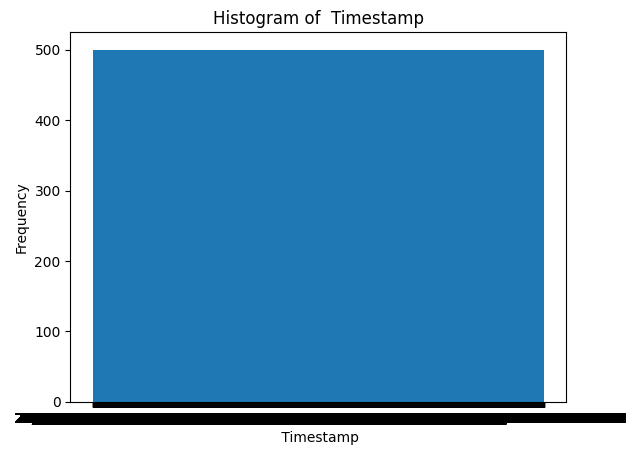

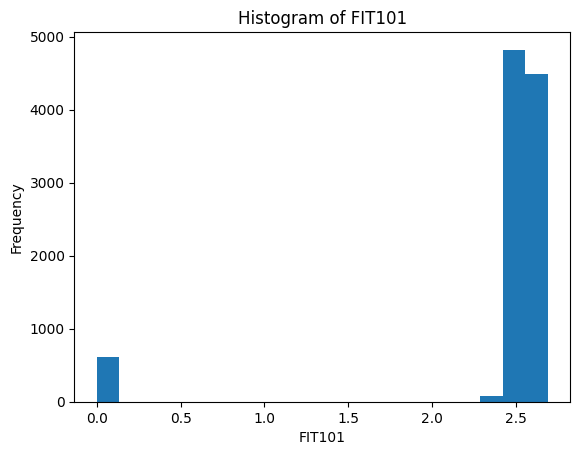

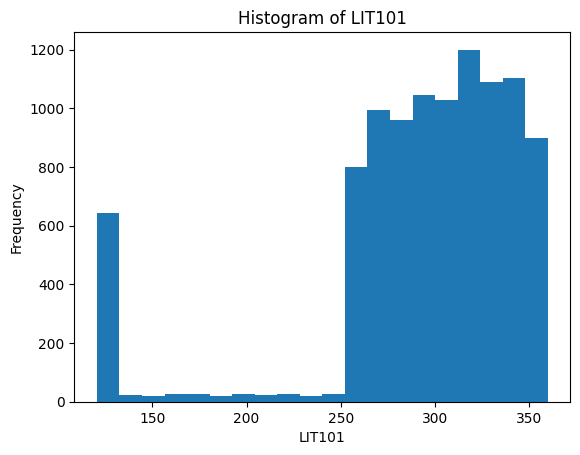

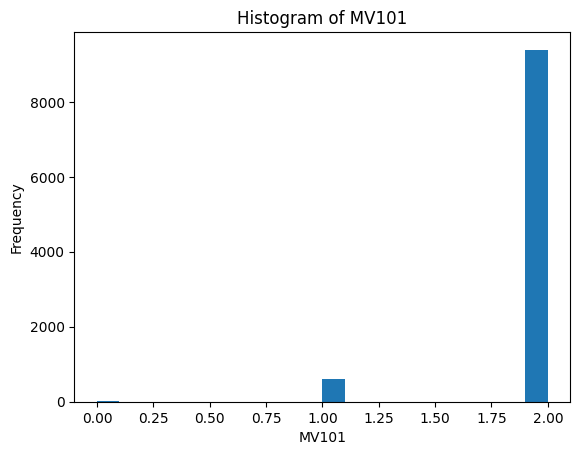

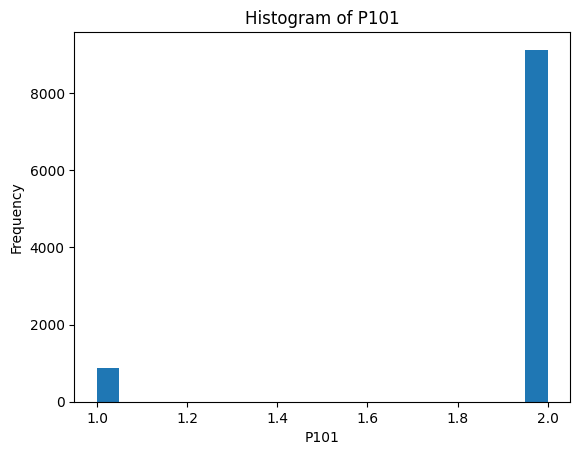

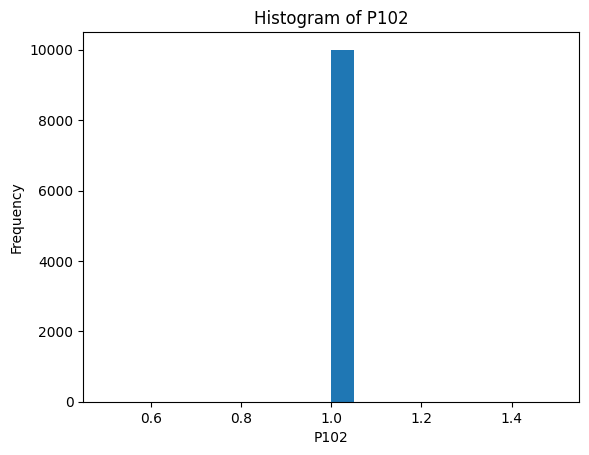

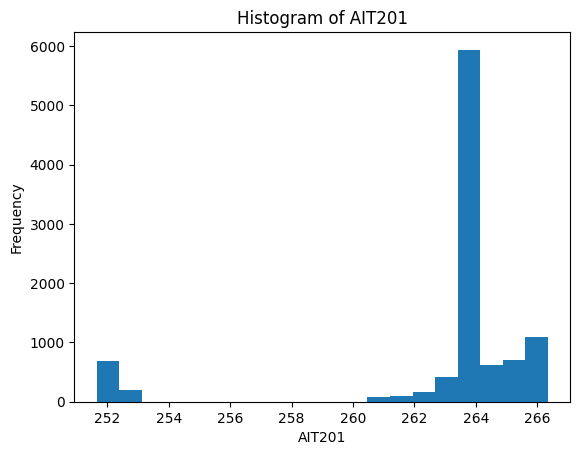

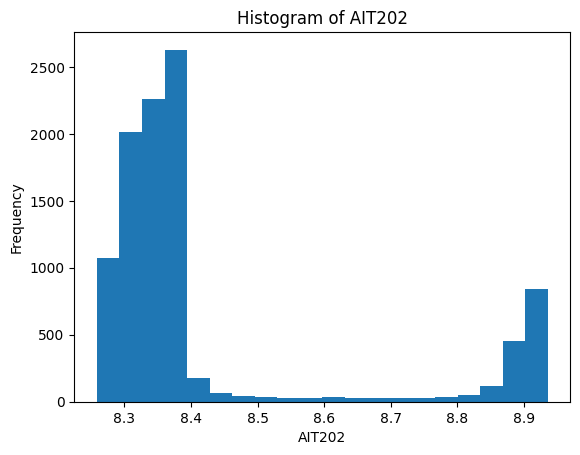

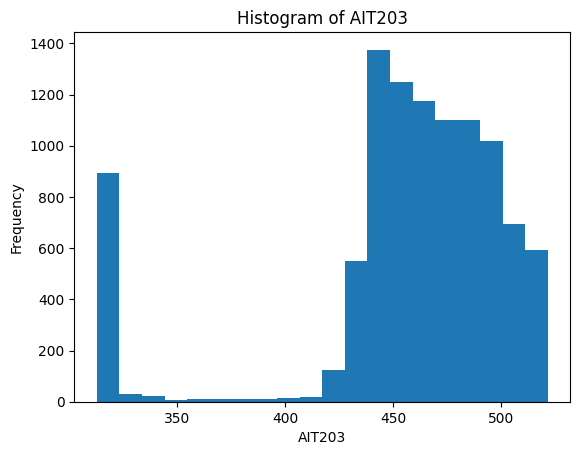

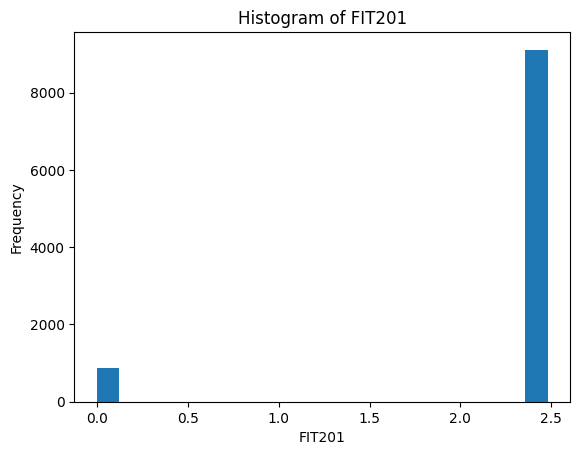

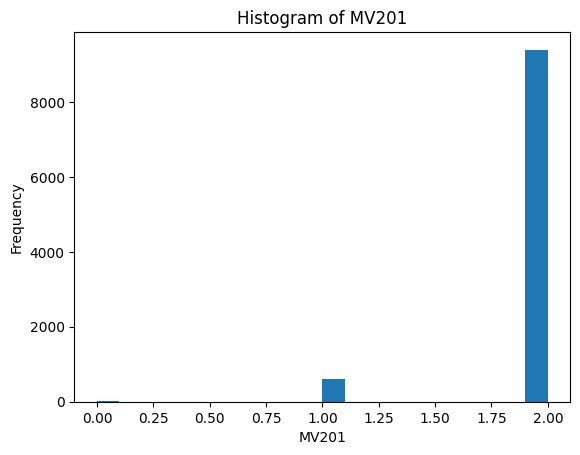

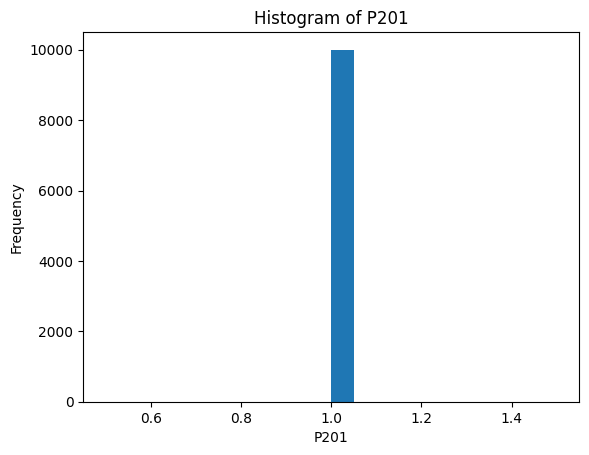

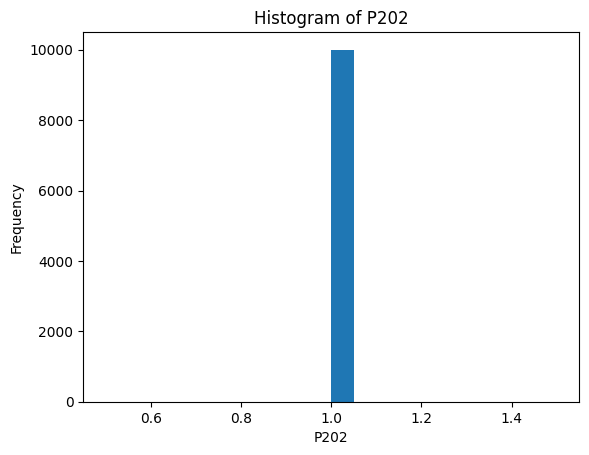

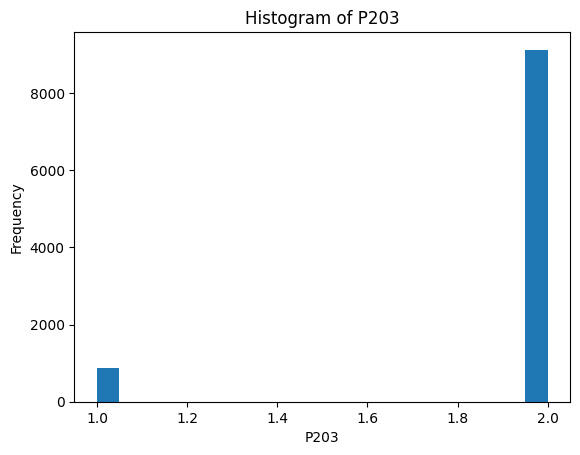

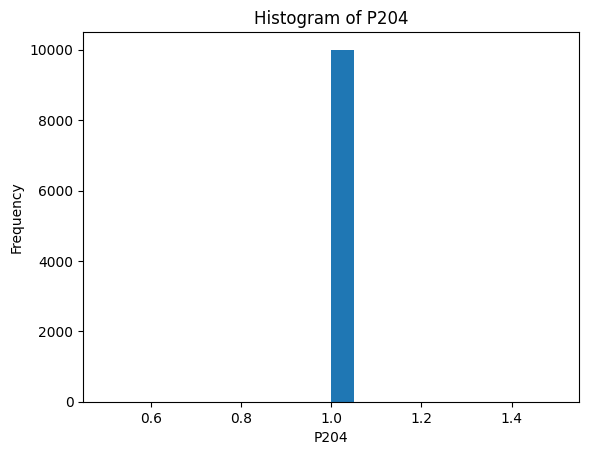

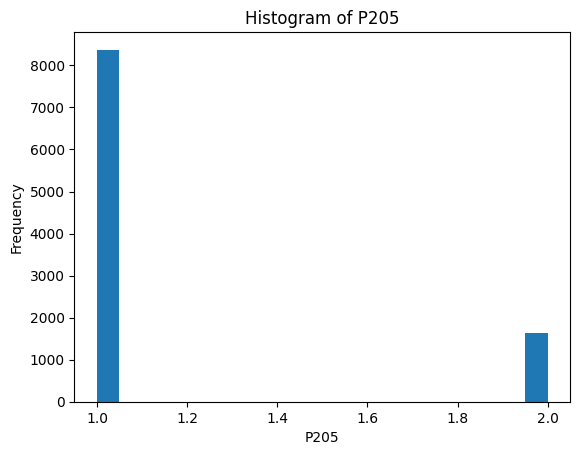

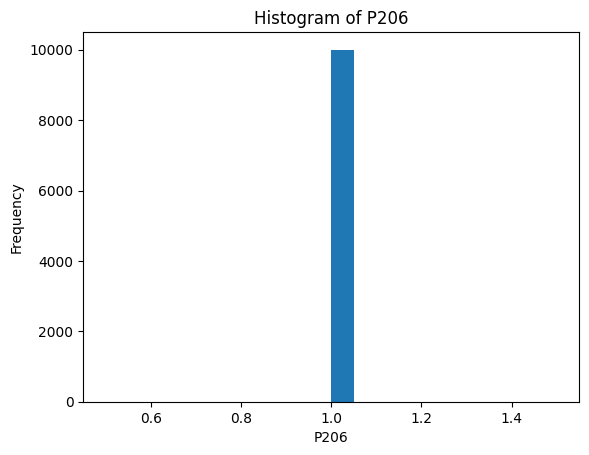

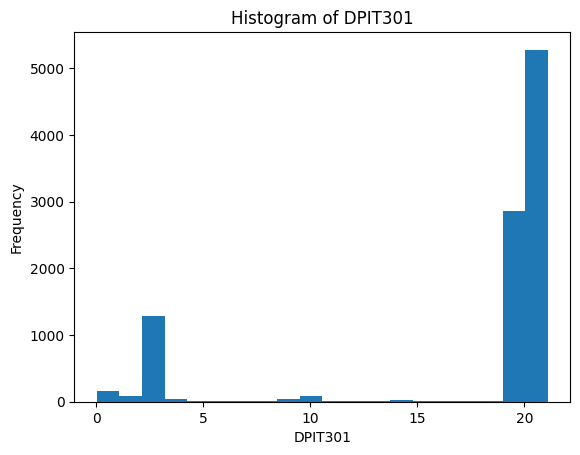

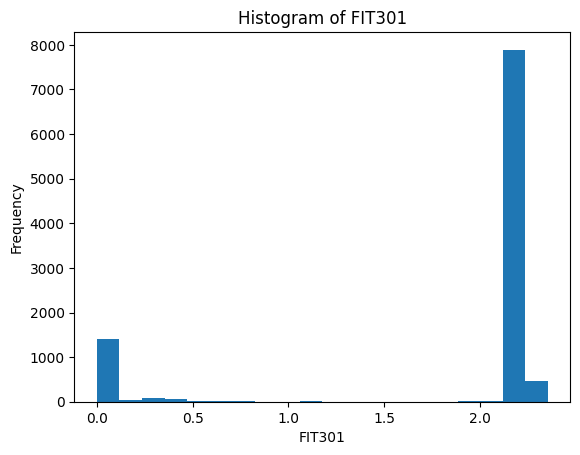

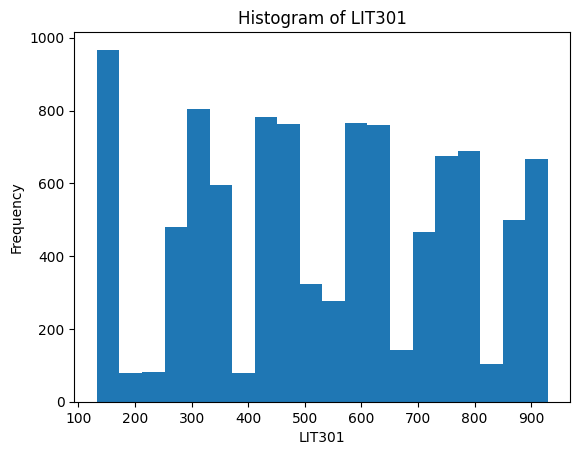

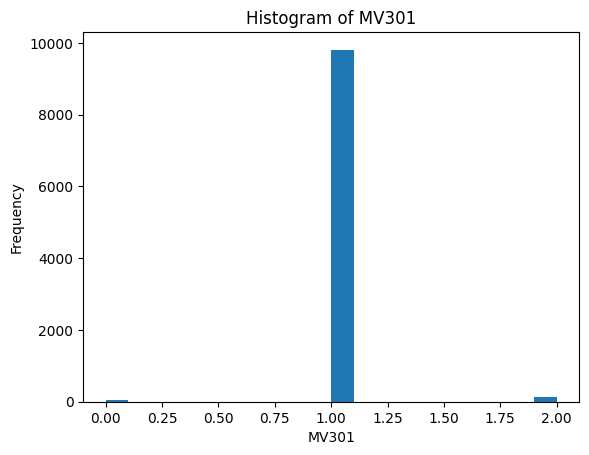

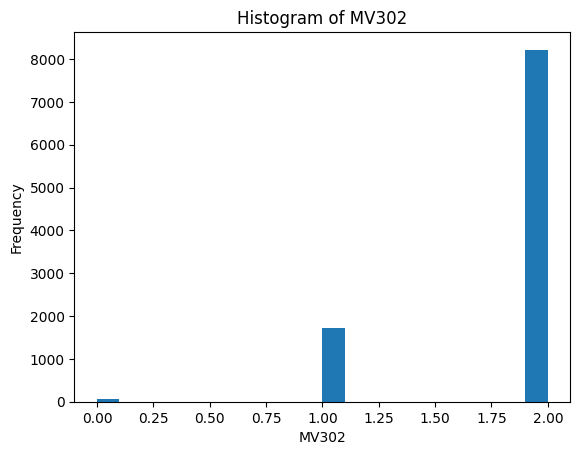

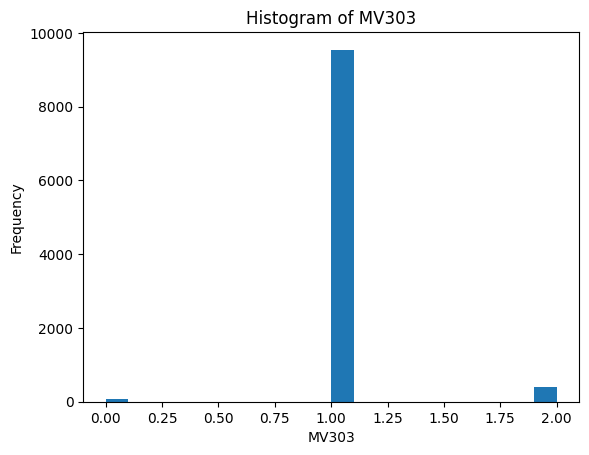

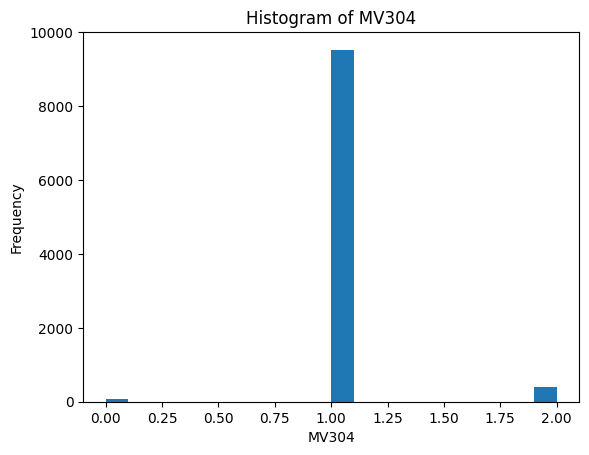

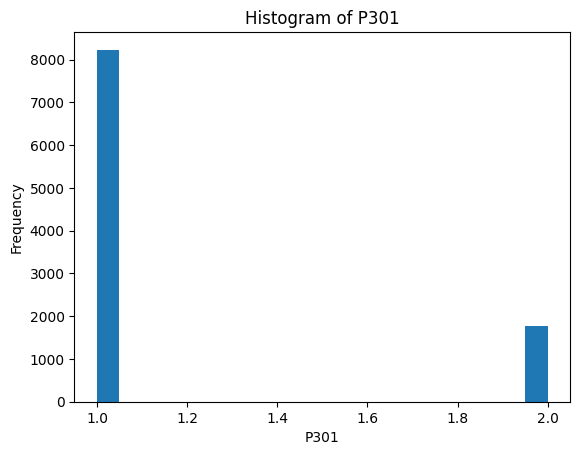

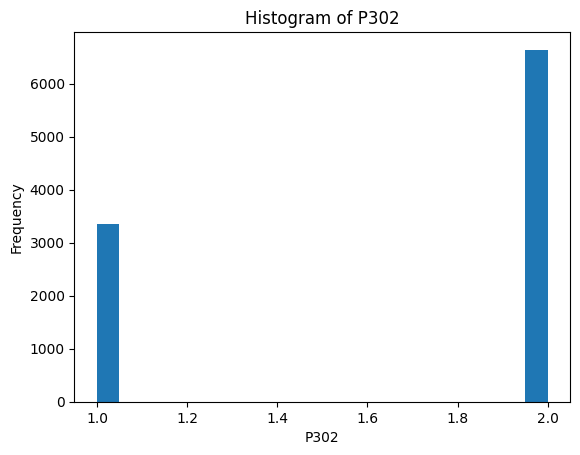

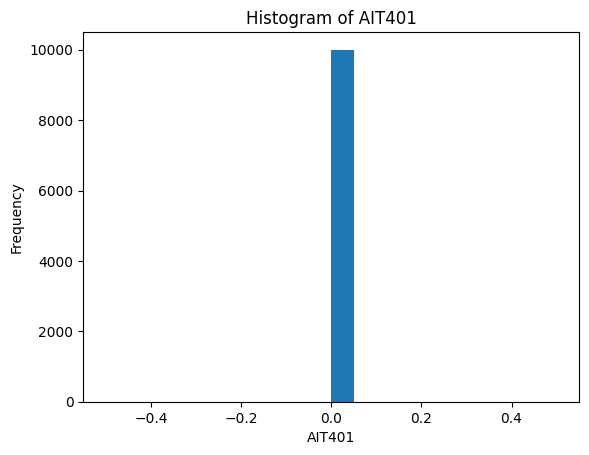

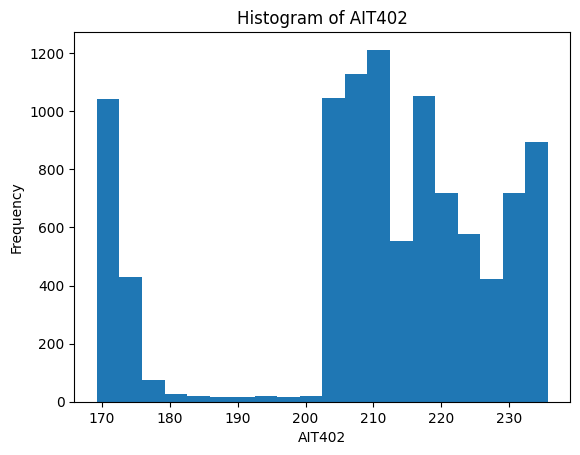

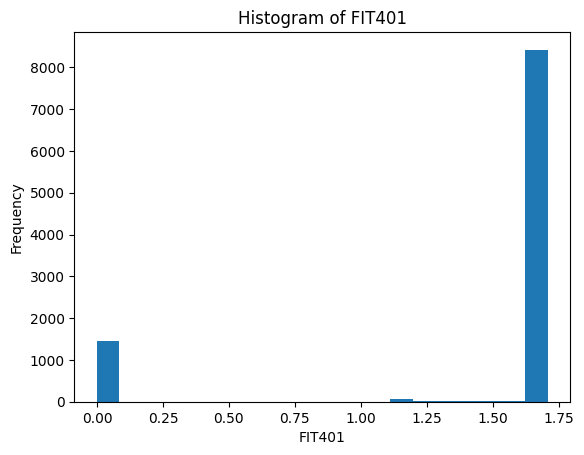

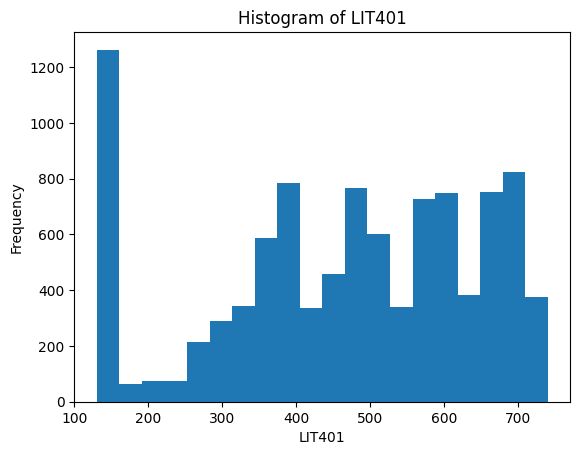

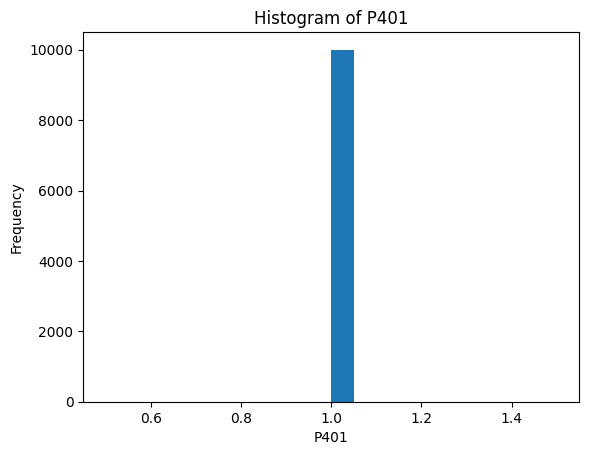

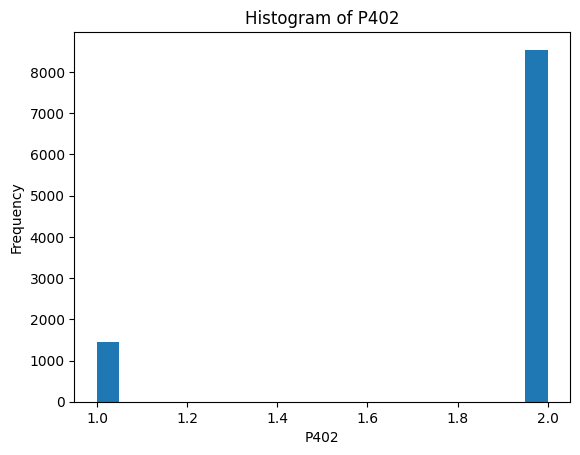

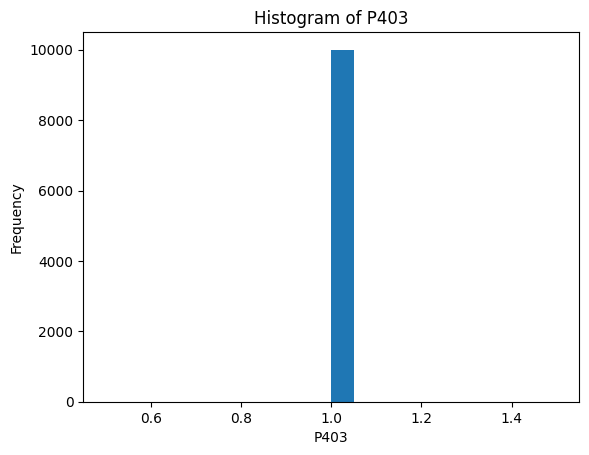

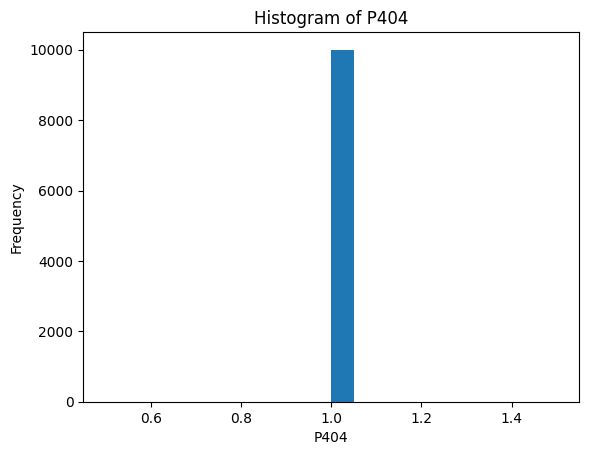

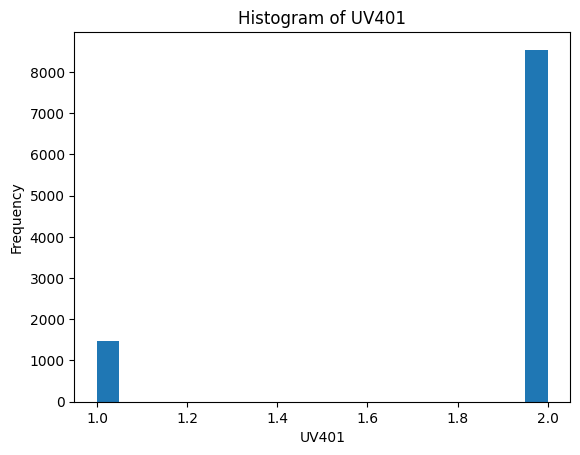

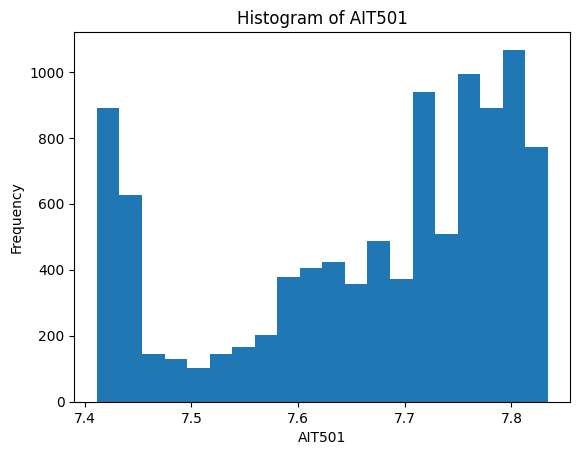

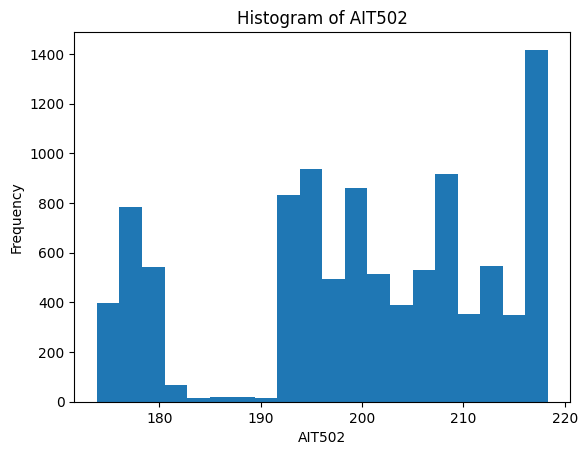

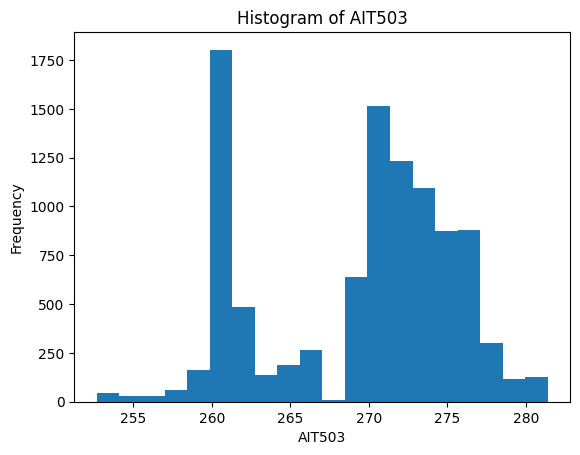

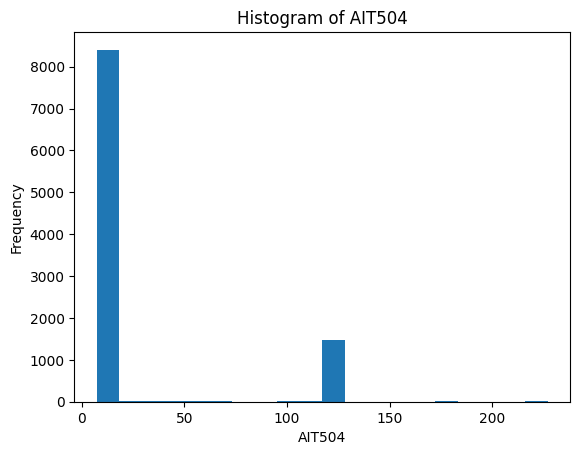

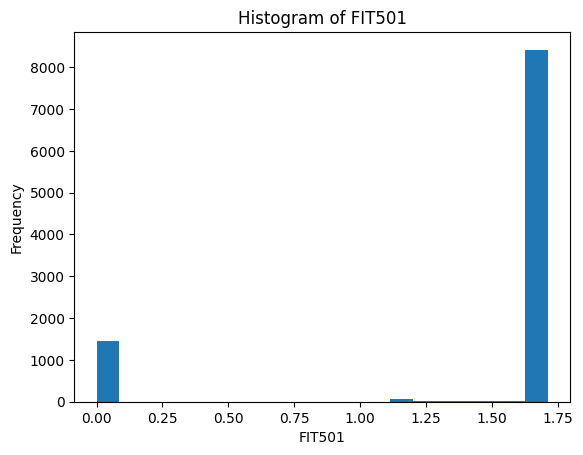

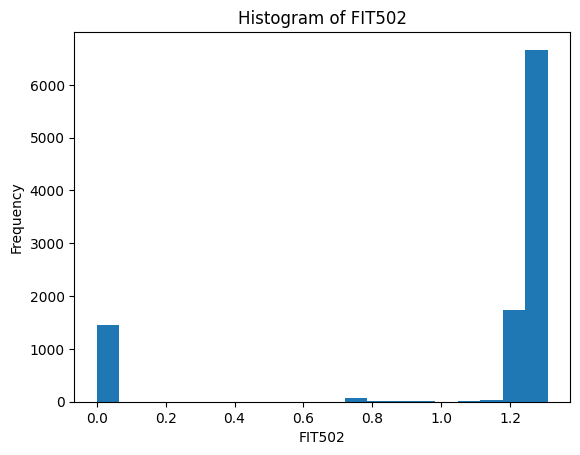

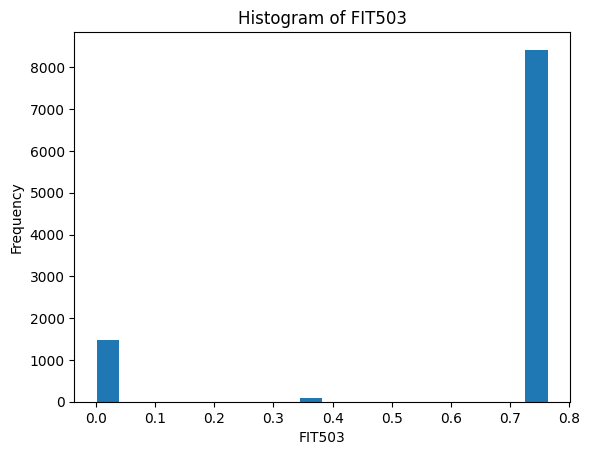

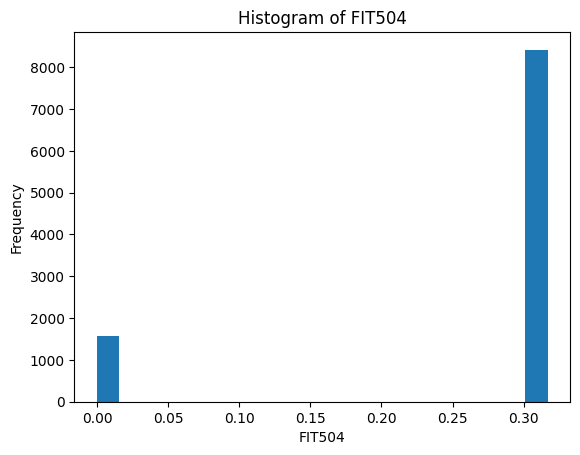

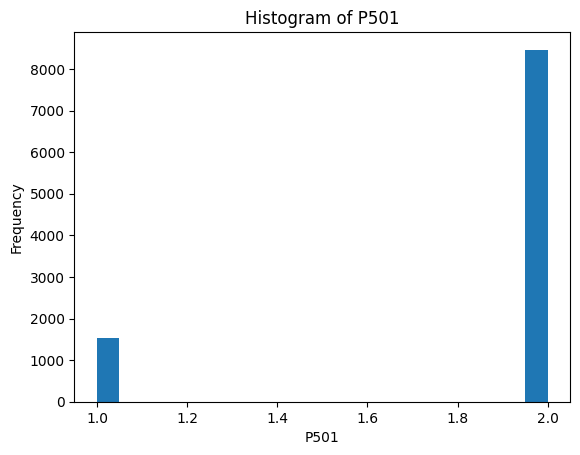

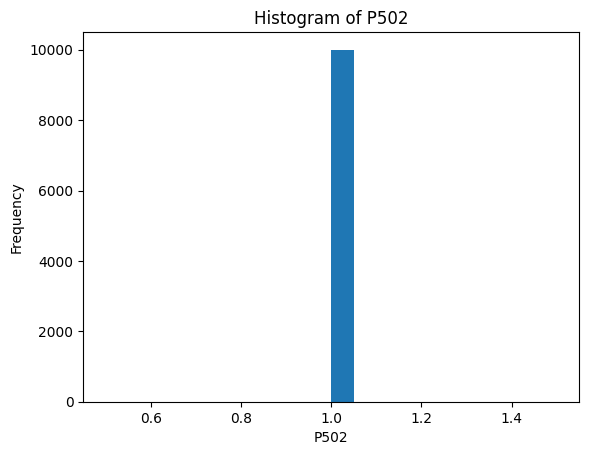

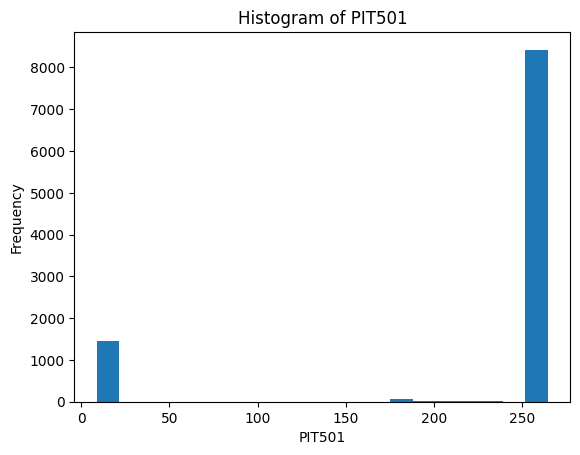

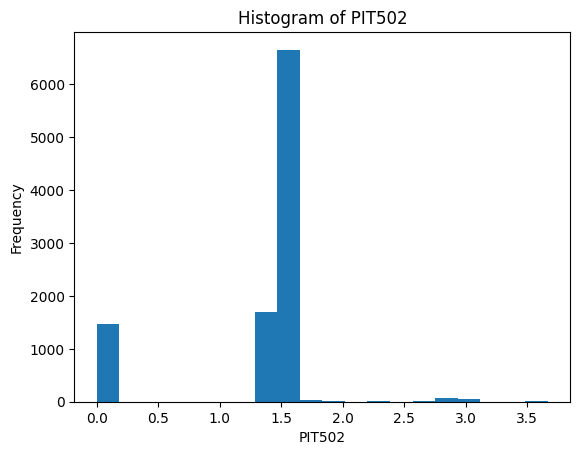

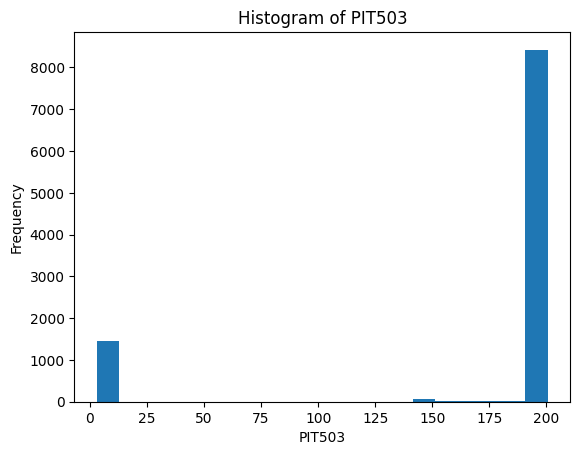

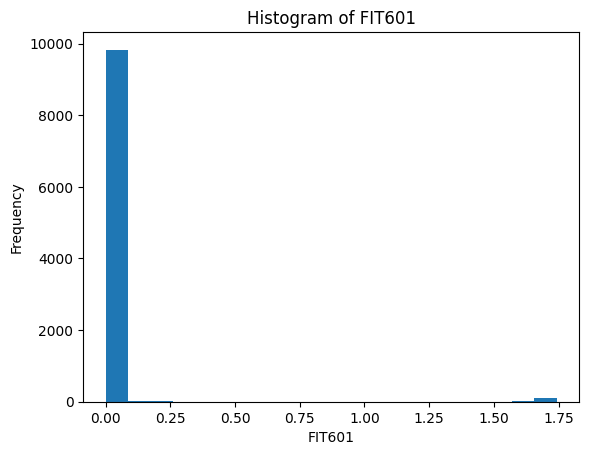

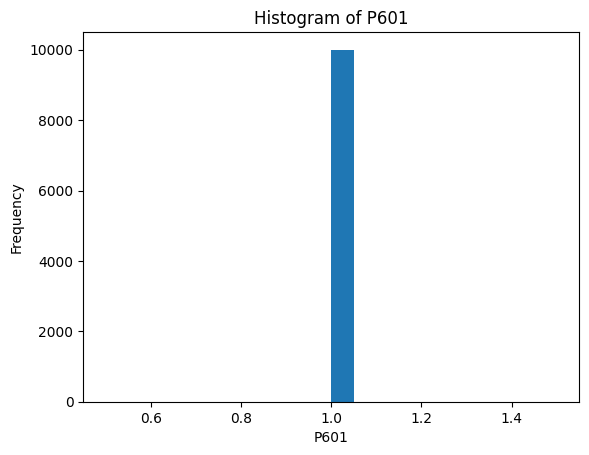

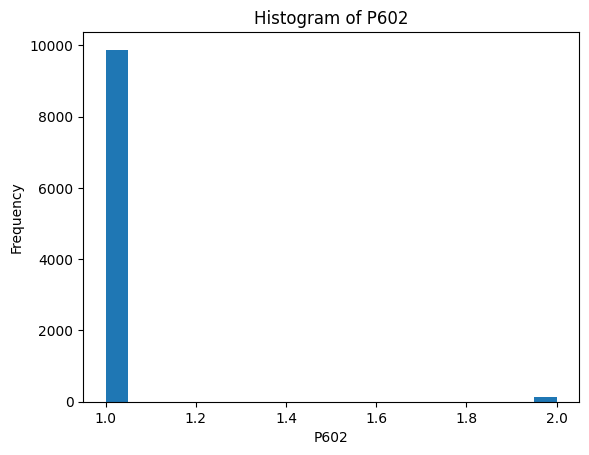

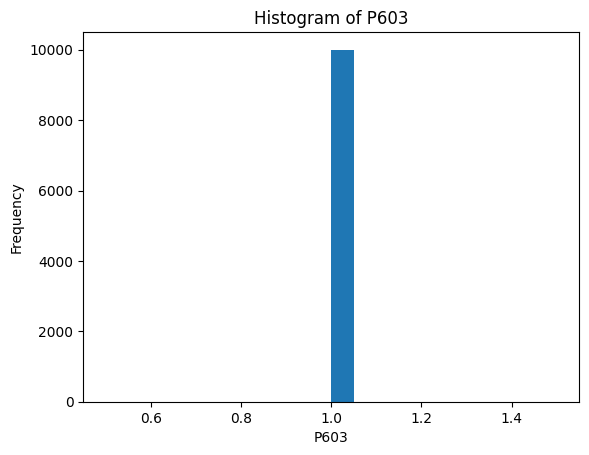

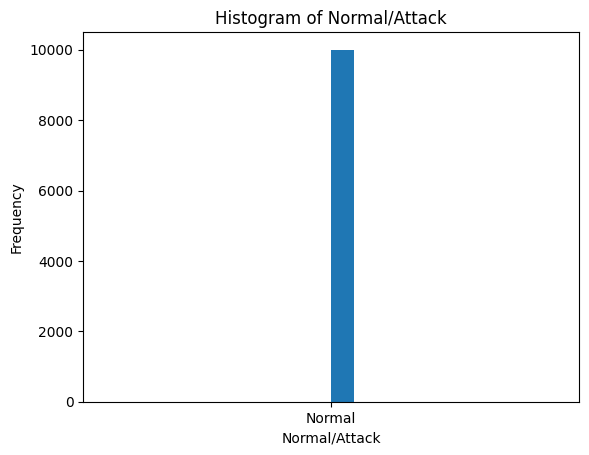

In [ ]:
df_his = df.iloc[:10000,:]

# Loop through each column in the DataFrame
for column in df.columns:
    # Create a histogram plot for the current column
    plt.hist(df_his[column], bins=20)  # Create a histogram with 20 bins
    plt.xlabel(column)  # Set the x-axis label as the column name
    plt.ylabel('Frequency')  # Set the y-axis label
    plt.title(f'Histogram of {column}')  # Set the title of the plot
    plt.show()  # Show the histogram plot

## Analysing the reason behind NaN values in correlation:
checking : Types, Nulls and Unique values 

In [ ]:
x_n.dtypes

In [ ]:
nan_count = x_n.isna().sum()
print(nan_count )

In [ ]:
uniqueValues = x_n.nunique()
df_unique = pd.DataFrame({'Column':uniqueValues.index, 'Unique':uniqueValues.values})
df_unique

### The NaN values are coming from columns having a single value which can be removed as it adds no information 
P202
p301
p401
p404
p502
p601
p603

Dropping unique single valued columns


In [ ]:
# drop_col_single_value = ['P202', 'P301', 'P401', 'P404', 'P502', 'P601', 'P603']

In [ ]:
# df.drop(drop_col_single_value, axis=1, inplace=True)

In [ ]:
# df.columns

In [ ]:
# # Retain upper triangular values of correlation matrix and
# # make Lower triangular values Null
# upper_corr_mat = corr_mat.where(
#     np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
  
# # Convert to 1-D series and drop Null values
# unique_corr_pairs = upper_corr_mat.unstack().dropna()

# #change to absolute value
# abs_unique_corr_pairs = unique_corr_pairs.abs()

# # Sort correlation pairs
# sorted_mat = abs_unique_corr_pairs.sort_values(ascending=False)
# print(sorted_mat)

Print top 10 values

In [ ]:
# sorted_mat.to_csv('file_name.csv')

In [ ]:
# print(sorted_mat[:15])

# Pre-processing

### Removing constant fields

In [30]:
fixed_value_fields = ['P202', 'P401', 'P404', 'P502', 'P601', 'P603']

In [31]:
x_n.drop(fixed_value_fields, axis=1, inplace=True)

In [32]:
x_n_an.drop(fixed_value_fields, axis=1, inplace=True)

In [33]:
x_n.shape

(495000, 45)

In [34]:
x_n_an.shape

(449919, 45)

### Merge all before one-hot encoding

In [35]:
merged_df = pd.concat([x_n, x_n_an], axis=0, ignore_index=True)

### one-hot encoding

In [36]:
merged_df = AD_normal.oneHotEncoding(fixed_value_fields, merged_df)

In [37]:
merged_df.shape

(944919, 91)

In [38]:
merged_df.columns

Index([ 'FIT101',  'LIT101',   'MV101',    'P101',    'P102',  'AIT201',
        'AIT202',  'AIT203',  'FIT201',   'MV201',    'P201',    'P203',
          'P204',    'P205',    'P206', 'DPIT301',  'FIT301',  'LIT301',
         'MV301',   'MV302',   'MV303',   'MV304',    'P301',    'P302',
        'AIT401',  'AIT402',  'FIT401',  'LIT401',    'P402',    'P403',
         'UV401',  'AIT501',  'AIT502',  'AIT503',  'AIT504',  'FIT501',
        'FIT502',  'FIT503',  'FIT504',    'P501',  'PIT501',  'PIT502',
        'PIT503',  'FIT601',    'P602',         0,         1,         2,
               3,         4,         5,         6,         7,         8,
               9,        10,        11,        12,        13,        14,
              15,        16,        17,        18,        19,        20,
              21,        22,        23,        24,        25,        26,
              27,        28,        29,        30,        31,        32,
              33,        34,        35,        36, 

In [39]:
# merged_df[merged_df.index < 5]

In [40]:
# x_n = AD_normal.oneHotEncoding(fixed_value_fields, x_n)

In [41]:
# x_n_an = AD_attack.oneHotEncoding(fixed_value_fields, x_n_an)

In [42]:
# x_n.shape

### Split all after one-hot encoding

In [43]:
# Split back into original DataFrames
x_n = merged_df[merged_df.index < len(x_n)]
x_n_an = merged_df[merged_df.index >= len(x_n)]

In [44]:
x_n

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,36,37,38,39,40,41,42,43,44,45
0,0.000000,124.3135,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.000000,124.3920,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.000000,124.4705,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.000000,124.6668,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.000000,124.5098,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494995,2.460366,523.0430,2,2,1,262.0161,8.396437,328.5055,2.442316,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
494996,2.448836,522.9645,2,2,1,262.0161,8.396437,328.5055,2.442316,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
494997,2.434744,522.8860,2,2,1,262.0161,8.396437,328.6337,2.444879,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
494998,2.428338,522.9252,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [45]:
# Reset the index
x_n_an.reset_index(drop=True, inplace=True)

In [46]:
x_n_an

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,36,37,38,39,40,41,42,43,44,45
0,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
449915,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
449916,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
449917,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [47]:
del merged_df

### Remvoe categoriacl fields after encoding

In [48]:
x_n = AD_normal.removeCategorical(fixed_value_fields, x_n)

<ipython-input-10-5b3f31506023>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_n.drop(new_cat_list, axis=1, inplace=True)


In [49]:
x_n_an = AD_attack.removeCategorical(fixed_value_fields, x_n_an)

<ipython-input-10-5b3f31506023>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_n.drop(new_cat_list, axis=1, inplace=True)


In [50]:
x_n.columns = x_n.columns.astype(str)

In [51]:
x_n_an.columns = x_n_an.columns.astype(str)

In [52]:
x_n.columns

Index(['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301',
       'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501',
       'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504',
       'PIT501', 'PIT502', 'PIT503', 'FIT601', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       '42', '43', '44', '45'],
      dtype='object')

In [53]:
x_n_an.columns

Index(['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301',
       'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501',
       'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504',
       'PIT501', 'PIT502', 'PIT503', 'FIT601', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       '42', '43', '44', '45'],
      dtype='object')

## Standardization

In [54]:
scaler_std = StandardScaler()

In [55]:
x_n_scaled = scaler_std.fit_transform(x_n)

In [56]:
x_n_an_scaled = scaler_std.fit_transform(x_n_an)

In [57]:
print(x_n_scaled)

[[ -1.63398414  -3.80729131  -2.47768267 ... -17.91219009   0.08948205
   -0.08948205]
 [ -1.63398414  -3.8066461   -2.47768267 ... -17.91219009   0.08948205
   -0.08948205]
 [ -1.63398414  -3.8060009   -2.47768267 ... -17.91219009   0.08948205
   -0.08948205]
 ...
 [  0.51586549  -0.53134468  -0.36920891 ...   0.0558279    0.08948205
   -0.08948205]
 [  0.51020907  -0.53102249  -0.36920891 ...   0.0558279    0.08948205
   -0.08948205]
 [  0.50907796  -0.5316677   -0.36920891 ...   0.0558279    0.08948205
   -0.08948205]]


## Normalization


In [58]:
# Normalization the data using MinMaxScaler
scaler = MinMaxScaler()

In [59]:
x_n_scaled = scaler.fit_transform(x_n)

In [60]:
x_n_an_scaled = scaler.fit_transform(x_n_an)

In [61]:
# savetxt('x_n.csv', x_n.iloc[:10000,:], delimiter=',')


In [62]:
x_n_scaled.shape

(495000, 71)

In [63]:
# Convert ndarray to pandas DataFrame
df_x_n_scaled = pd.DataFrame(x_n_scaled)
df_x_n_an_scaled = pd.DataFrame(x_n_an_scaled)

In [64]:
from scipy.stats import pearsonr
import itertools
import math




# Initialize an empty dictionary to store the Pearson correlation coefficients
pearson_dict = {}

# Compute Pearson correlation coefficients for all pairs of features
for col1, col2 in itertools.combinations(df_x_n_scaled.columns, 2):
    # Compute Pearson correlation coefficient for the current pair of features
    corr, _ = pearsonr(df_x_n_scaled[col1], df_x_n_scaled[col2])
    pearson_dict[f"{col1}-{col2}"] = abs(corr)  # Store the absolute correlation coefficient

# Remove NaN values using a loop
pearson_dict_without_nan = {}
for k, v in pearson_dict.items():
    if not isinstance(v, float) or not math.isnan(v):
        pearson_dict_without_nan[k] = v


# Sort the Pearson correlation coefficients in descending order
sorted_pearson = sorted(pearson_dict_without_nan.items(), key=lambda x: x[1], reverse=True)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [65]:
sorted_pearson

[('28-29', 1.0),
 ('57-58', 1.0),
 ('59-60', 1.0),
 ('61-62', 1.0),
 ('65-66', 1.0),
 ('67-68', 1.0),
 ('69-70', 1.0),
 ('41-42', 0.9999999999999892),
 ('37-38', 0.9999999999998137),
 ('11-17', 0.9997261128467624),
 ('61-65', 0.9989711471970937),
 ('61-66', 0.9989711471970937),
 ('62-65', 0.9989711471970937),
 ('62-66', 0.9989711471970937),
 ('21-23', 0.9987406580913246),
 ('28-34', 0.997403864952071),
 ('29-34', 0.997403864952071),
 ('5-37', 0.9961842551522856),
 ('5-38', 0.9961842551522856),
 ('28-37', 0.9927049716547407),
 ('28-38', 0.9927049716547407),
 ('29-37', 0.9927049716547407),
 ('29-38', 0.9927049716547407),
 ('34-37', 0.9923308373800557),
 ('34-38', 0.9923308373800557),
 ('5-28', 0.9920023946393149),
 ('5-29', 0.9920023946393149),
 ('5-34', 0.9916078424585199),
 ('0-26', 0.9911986847340615),
 ('19-21', 0.9910655421514248),
 ('19-20', 0.9908039735463314),
 ('0-27', 0.9907420457219962),
 ('33-34', 0.9903210943325752),
 ('26-27', 0.9899119270843928),
 ('5-33', 0.98903669050231

In [66]:
# Select feature pairs based on a threshold correlation coefficient
threshold = 0.6  # Set your desired threshold value here
selected_feature_pairs = [(pair.split('-')[0], pair.split('-')[1]) for pair, corr in sorted_pearson if corr >= threshold]

In [67]:
selected_feature_pairs

[('28', '29'),
 ('57', '58'),
 ('59', '60'),
 ('61', '62'),
 ('65', '66'),
 ('67', '68'),
 ('69', '70'),
 ('41', '42'),
 ('37', '38'),
 ('11', '17'),
 ('61', '65'),
 ('61', '66'),
 ('62', '65'),
 ('62', '66'),
 ('21', '23'),
 ('28', '34'),
 ('29', '34'),
 ('5', '37'),
 ('5', '38'),
 ('28', '37'),
 ('28', '38'),
 ('29', '37'),
 ('29', '38'),
 ('34', '37'),
 ('34', '38'),
 ('5', '28'),
 ('5', '29'),
 ('5', '34'),
 ('0', '26'),
 ('19', '21'),
 ('19', '20'),
 ('0', '27'),
 ('33', '34'),
 ('26', '27'),
 ('5', '33'),
 ('16', '20'),
 ('28', '33'),
 ('29', '33'),
 ('11', '65'),
 ('11', '66'),
 ('19', '68'),
 ('19', '67'),
 ('20', '68'),
 ('20', '67'),
 ('17', '66'),
 ('17', '65'),
 ('11', '61'),
 ('11', '62'),
 ('19', '23'),
 ('17', '61'),
 ('17', '62'),
 ('6', '50'),
 ('16', '67'),
 ('16', '68'),
 ('33', '37'),
 ('33', '38'),
 ('19', '66'),
 ('19', '65'),
 ('6', '49'),
 ('19', '61'),
 ('19', '62'),
 ('10', '14'),
 ('11', '67'),
 ('11', '68'),
 ('16', '19'),
 ('17', '68'),
 ('17', '67'),
 ('17

In [68]:
# Extract the feature names from the selected feature pairs
selected_features = set([feature for pair in selected_feature_pairs for feature in pair])

In [69]:
# Convert the selected feature names from strings to numeric format
selected_features_numeric = [float(feature) for feature in selected_features]

# Sort the selected feature names in ascending order
selected_features_numeric.sort()  # To sort in descending order, use selected_features_numeric.sort(reverse=True)

# Filter the DataFrame to keep only the selected features
df_x_n_scaled[selected_features_numeric]

,0,1,2,4,5,6,7,8,9,10,...,59,60,61,62,65,66,67,68,69,70
0,0.000000,0.005294,0.012291,0.002009,0.000000,0.121378,0.000109,0.006449,0.000000,0.188674,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.000000,0.005407,0.012291,0.002009,0.000000,0.121378,0.000109,0.006722,0.000000,0.188674,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.000000,0.005520,0.012291,0.002009,0.000000,0.121378,0.000109,0.006586,0.000000,0.188674,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.000000,0.005801,0.012291,0.002009,0.000000,0.121378,0.000109,0.006676,0.000000,0.188674,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.000000,0.005576,0.012291,0.002009,0.000000,0.121378,0.000109,0.006903,0.000000,0.188674,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494995,0.896278,0.577415,0.496158,0.063586,0.981663,0.935973,0.937812,0.933191,0.999677,0.028160,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
494996,0.892078,0.577302,0.496158,0.063586,0.981663,0.935973,0.936943,0.933282,0.999677,0.028160,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
494997,0.886944,0.577190,0.496158,0.064088,0.982693,0.935973,0.935965,0.933372,0.999677,0.028160,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
494998,0.884611,0.577246,0.496158,0.064088,0.982899,0.935973,0.935586,0.933645,0.999677,0.028160,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [70]:
print(x_n_scaled)
print(len(x_n_scaled))

[[0.         0.00529434 0.01229141 ... 0.         1.         0.        ]
 [0.         0.00540698 0.01229141 ... 0.         1.         0.        ]
 [0.         0.00551961 0.01229141 ... 0.         1.         0.        ]
 ...
 [0.88694441 0.57718951 0.49615774 ... 1.         1.         0.        ]
 [0.88461079 0.57724575 0.49615774 ... 1.         1.         0.        ]
 [0.88414414 0.57713312 0.49615774 ... 1.         1.         0.        ]]
495000


In [71]:
x_n_scaled = df_x_n_scaled[selected_features_numeric].values

In [72]:
x_n_an_scaled = df_x_n_an_scaled[selected_features_numeric].values

In [73]:
print(x_n_scaled)
print(len(x_n_scaled))

[[0.         0.00529434 0.01229141 ... 0.         1.         0.        ]
 [0.         0.00540698 0.01229141 ... 0.         1.         0.        ]
 [0.         0.00551961 0.01229141 ... 0.         1.         0.        ]
 ...
 [0.88694441 0.57718951 0.49615774 ... 1.         1.         0.        ]
 [0.88461079 0.57724575 0.49615774 ... 1.         1.         0.        ]
 [0.88414414 0.57713312 0.49615774 ... 1.         1.         0.        ]]
495000


In [74]:
x_n_scaled.shape

(495000, 53)

# Correlation Probabilistic Model

In [80]:
window_size = 128
shift = 8

## Create the windowed data

In [81]:
y_n_an.shape

(449919, 1)

In [82]:
x_w_train = AD_normal.createSequence(x_n_scaled[:,:], window_size, shift)

In [ ]:
x_w_train_an = AD_normal.createSequence(x_n_an_scaled[:,:], window_size,  shift)
y_w_train_an = AD_normal.createSequence(y_n_an[:], window_size, shift)

In [ ]:
x_w_train.shape

In [ ]:
x_w_train_an.shape

## Create LCM and LCV within the loop directly from the windowed data

In [ ]:
del df, df_an
del x_n
del x_n_an
del x_n_scaled
# del x_n_an_scaled

del x_w_train
# del x_w_train_an
# del y_w_train_an
del y_n
# del y_n_an

### Calculate correlation

#### normal part

In [83]:
%cd '/content/drive/My Drive/Colab Notebooks/Thesis/LCVs_all/SWaT/spearman/w128_s8/training/'

/content/drive/My Drive/Colab Notebooks/Thesis/LCVs_all/SWaT/spearman/w128_s8/training


In [ ]:
LCVs = []
LCVs = AD_normal.calculateLCV_spearman(x_w_train[:50000,:,:])

100 

200 

300 

400 

500 

600 

700 

800 

900 

1000 

1100 

1200 

1300 

1400 

1500 

1600 

1700 

1800 

1900 

2000 

2100 

2200 

2300 

2400 

2500 

2600 

2700 

2800 

2900 

3000 

3100 

3200 

3300 

3400 

3500 

3600 

3700 

3800 

3900 

4000 

4100 

4200 

4300 

4400 

4500 

4600 

4700 

4800 

4900 

5000 

5100 

5200 

5300 

5400 

5500 

5600 

5700 

5800 

5900 

6000 

6100 

6200 

6300 

6400 

6500 

6600 

6700 

6800 

6900 

7000 

7100 

7200 

7300 

7400 

7500 

7600 

7700 

7800 

7900 

8000 

8100 

8200 

8300 

8400 

8500 

8600 

8700 

8800 

8900 

9000 

9100 

9200 

9300 

9400 

9500 

9600 

9700 

9800 

9900 

10000 

10100 

10200 

10300 

10400 

10500 

10600 

10700 

10800 

10900 

11000 

11100 

11200 

11300 

11400 

11500 

11600 

11700 

11800 

11900 

12000 

12100 

12200 

12300 

12400 

12500 

12600 

12700 

12800 

12900 

13000 

13100 

13200 

13300 

13400 

13500 

13600 

13700 

13800 

1390

In [ ]:
# Open a file for writing
with open('LCVs_1.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs, f)

In [ ]:
LCVs = []
LCVs = AD_normal.calculateLCV_spearman(x_w_train[50000:,:,:])

In [ ]:
# Open a file for writing
with open('LCVs_2.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs, f)

In [ ]:
del x_w_train

Load LCVs partitions

In [ ]:
# Load the pickle file
with open('LCVs_1.pickle', 'rb') as f:
    sample_normal_1 = pickle.load(f)

In [ ]:
# Load the pickle file
with open('LCVs_2.pickle', 'rb') as f:
    sample_normal_2 = pickle.load(f)

In [ ]:
LCVs = sample_normal_1 + sample_normal_2 #+ sample_normal_3 #+ sample_normal_4 + sample_normal_5 #+ sample_normal_6

In [ ]:
import gc

# ... code that creates objects ...
# del LCVs
del sample_normal_1, sample_normal_2#, sample_normal_3
# del sample_normal_4, sample_normal_5 , sample_normal_6

# Trigger garbage collection
gc.collect()

0

In [ ]:
len(LCVs)

61858

#### anomaly part

In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/Thesis/LCVs_all/SWaT/spearman/w128_s8/testing/'

/content/drive/My Drive/Colab Notebooks/Thesis/LCVs_all/SWaT/pearson/w128_s8/testing


In [ ]:
# del x_w_train, LCVs

In [ ]:
LCVs_an_y = AD_normal.getLabels(y_w_train_an[:,:,:])

In [ ]:
df_LCVs_an_y = pd.DataFrame(LCVs_an_y)

In [ ]:
df_LCVs_an_y.value_counts()

0    41766
1     8171
dtype: int64

In [ ]:
# df_LCVs_an_y.value_counts()

0    396352
1     53536
dtype: int64

In [ ]:
# Open a file for writing
with open('LCVs_an_y.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs_an_y, f)

In [ ]:
LCVs_an = []
LCVs_an = AD_normal.calculateLCV_spearman(x_w_train_an[:50000,:,:])

In [ ]:
# Open a file for writing
with open('LCVs_an_1.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs_an, f)

In [ ]:
LCVs_an = []
LCVs_an = AD_normal.calculateLCV_spearman(x_w_train_an[50000:,:,:])

In [ ]:
# Open a file for writing
with open('LCVs_an_2.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs_an, f)

Load LCVs with attack partitions

In [ ]:
# Load the pickle file
with open('LCVs_an_y.pickle', 'rb') as f:
    LCVs_an_y = pickle.load(f)

In [ ]:
# Load the pickle file
with open('LCVs_an_1.pickle', 'rb') as f:
    sample_attack_1 = pickle.load(f)

In [ ]:
# Load the pickle file
with open('LCVs_an_2.pickle', 'rb') as f:
    sample_attack_2 = pickle.load(f)

In [ ]:
LCVs_an = sample_attack_1 + sample_attack_2 #+ sample_attack_3

In [ ]:
import gc

# ... code that creates objects ...
del sample_attack_1, sample_attack_2

# Trigger garbage collection
gc.collect()

0

In [ ]:
len(LCVs_an)

56223

In [ ]:
pd.Series(LCVs_an_y).value_counts()

0    48856
1     7367
dtype: int64

## Split Validation and Testing data

In [ ]:
from sklearn.model_selection import train_test_split


# Splitting the data into training and testing sets with stratified sampling
X_test, X_valid, y_test, y_valid = train_test_split(LCVs_an, LCVs_an_y, train_size=0.5, stratify=LCVs_an_y, random_state=42)

## Calculate the mean and covariance matrix of all LCVs

In [ ]:
# Compute the mean and covariance matrix of the windowed data
mean_vector = np.mean(LCVs, axis=0)
covariance_matrix = np.cov(LCVs, rowvar=False)

## Define the multivariate Gaussian distribution with the mean and covariance


In [ ]:
print(AD_normal.checkPosDef(covariance_matrix))

True


In [ ]:
# Define the multivariate Gaussian distribution with the mean and covariance
mvn = AD_normal.MGD(mean_vector, covariance_matrix)

In [ ]:
# Compute the log-likelihood of the data given the estimated mean and covariance
log_likelihood = np.sum(mvn.logpdf(LCVs))

## Finding anomaly


### predict with Epsilon

In [ ]:
# !! crashed
pdf_an = mvn.logpdf(X_valid)
pdf_an

array([1257.27717432, 1164.66084284, 1233.19508665, ..., 1102.12497464,
       1238.81238884, 1108.00293037])

In [ ]:
best_f1, best_epsilon, cm = AD_normal.select_threshold(pdf_an, y_valid)

In [ ]:
# 
print(best_epsilon)

929.2204265798637


In [ ]:
pdf_an_ = mvn.logpdf(X_test)
pdf_an_

array([1065.41430088, 1233.55537845, 1236.84485625, ..., 1000.32196265,
       1266.89864637, 1299.67748352])

In [ ]:
# confusion matrix
predictions = (pdf_an_ < best_epsilon)
cm = confusion_matrix(y_test, predictions)

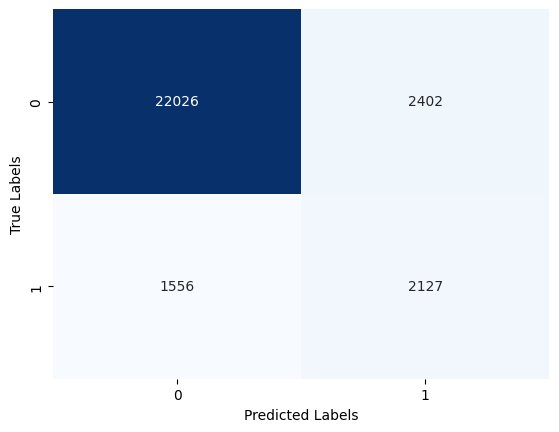

In [ ]:
# Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Check the model performance
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92     24428
           1       0.47      0.58      0.52      3683

    accuracy                           0.86     28111
   macro avg       0.70      0.74      0.72     28111
weighted avg       0.87      0.86      0.87     28111



### predict with Alpha

In [ ]:
# from sklearn.model_selection import StratifiedKFold

# # Define the number of folds for cross-validation
# k = 5

# # Define the cross-validation method
# cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)


# # Evaluate the model using cross-validation
# f1_list = []
# alpha_list = []
# cm_list = []
# for valid_index, test_index in cv.split(X_valid, y_valid):
#     _, X_valid_ = [LCVs_an[i] for i in valid_index], [LCVs_an[i] for i in test_index]
#     _, y_valid_ = [LCVs_an_y[i] for i in valid_index], [LCVs_an_y[i] for i in test_index]

#     best_f1, best_alpha, cm  = AD_normal.findBestAlpha(X_valid_, y_valid_,covariance_matrix, mean_vector)
#     f1_list.append(best_f1)
#     alpha_list.append(best_alpha)
#     cm_list.append(cm)

In [ ]:
# # Get the index of the highest value in the list
# highest_index = f1_list.index(max(f1_list))

In [ ]:
# best_f1, best_alpha = f1_list[highest_index], alpha_list[highest_index]

In [ ]:
# cm = cm_list[highest_index]

In [ ]:
best_f1, best_alpha, cm  = AD_normal.findBestAlpha(X_valid, y_valid,covariance_matrix, mean_vector)

In [ ]:
best_alpha

122

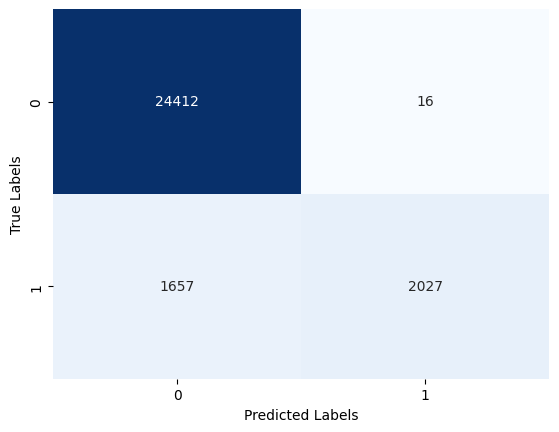

In [ ]:
# Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
y_pred = AD_normal.predictWithAlpha(LCVs_an, covariance_matrix, mean_vector, best_alpha)

In [ ]:
cm = confusion_matrix(LCVs_an_y, y_pred)

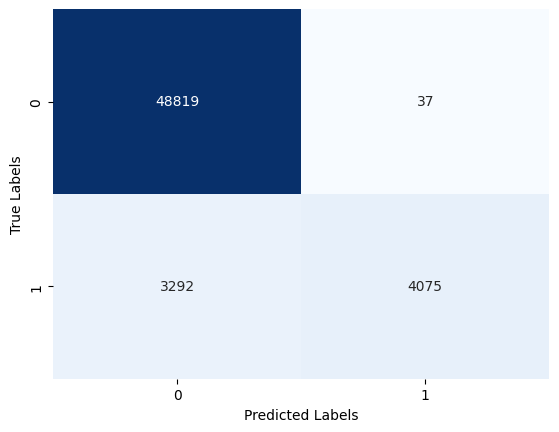

In [ ]:
# Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
pd.Series(LCVs_an_y).value_counts()

0    48856
1     7367
dtype: int64

In [ ]:
pd.Series(y_pred).value_counts()

0    52111
1     4112
dtype: int64

In [ ]:
from sklearn.metrics import classification_report
# Check the model performance
print(classification_report(LCVs_an_y, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     48856
           1       0.99      0.55      0.71      7367

    accuracy                           0.94     56223
   macro avg       0.96      0.78      0.84     56223
weighted avg       0.94      0.94      0.93     56223



# Visualization

In [ ]:
LCVs_an_pdf = mvn.logpdf(LCVs_an)


### predict with Alpha

In [ ]:
# LCVs_an, LCVs_an_y
LCVs_an_pred  = AD_normal.predictWithAlpha(LCVs_an, covariance_matrix, mean_vector, best_alpha)

In [ ]:
LCVs_an_pred

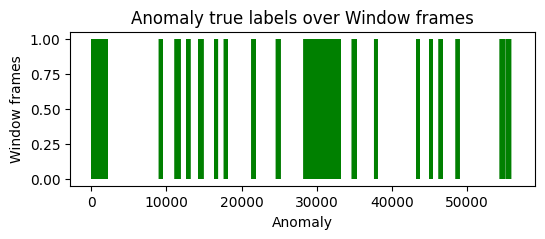

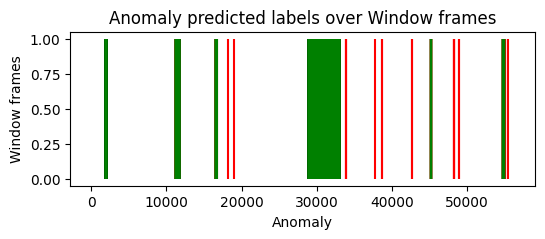

In [ ]:
# Define the range of parameter values to test
size = len(LCVs_an_y)
parameter_range = np.linspace(1, size, size)

# Define the range of parameter values to test
size = LCVs_an_pdf.size
parameter_range = np.linspace(1, size, size)

# Convert LCVs_an_y and LCVs_an_pred to numpy arrays
LCVs_an_y_arr = np.array(LCVs_an_y)
LCVs_an_pred_arr = np.array(LCVs_an_pred)

equal_indices = LCVs_an_y_arr == LCVs_an_pred_arr

plt.figure(figsize=(6, 2))
plt.vlines(parameter_range, 0, LCVs_an_y_arr, colors='green')
plt.ylabel('Window frames')
plt.xlabel('Anomaly')
plt.title('Anomaly true labels over Window frames')
plt.show()

plt.figure(figsize=(6, 2))
plt.vlines(parameter_range, 0, LCVs_an_pred_arr, colors='red')
plt.vlines(parameter_range[equal_indices], 0, LCVs_an_pred_arr[equal_indices], colors='green')
# plt.vlines(parameter_range[~equal_indices], 0, LCVs_an_y_arr[~equal_indices], colors='gray')
plt.ylabel('Window frames')
plt.xlabel('Anomaly')
plt.title('Anomaly predicted labels over Window frames')
plt.show()

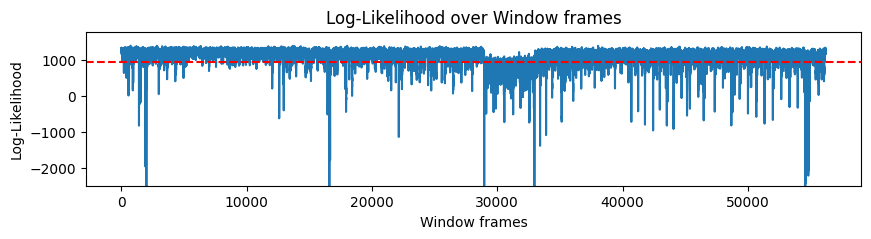

In [ ]:
# Define the range of parameter values to test
size = len(LCVs_an_pdf)
parameter_range = np.linspace(1, size, size)

plt.figure(figsize=(10, 2))
plt.plot(parameter_range, LCVs_an_pdf)
plt.xlabel('Window frames')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood over Window frames')
# Add a constant line at y = -2000
plt.axhline(y=best_epsilon, color='r', linestyle='--')
plt.ylim([-2500, None])
plt.show()

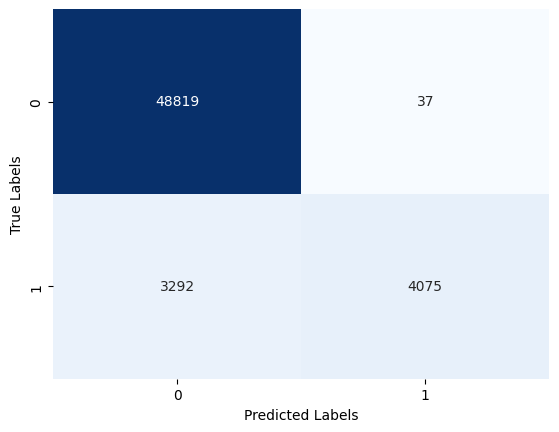

In [ ]:
cm_all = confusion_matrix(LCVs_an_y, LCVs_an_pred)
# Plot confusion matrix using seaborn
sns.heatmap(cm_all, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()